In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import eig
from matplotlib.patches import Ellipse
from sklearn.datasets import make_spd_matrix

In [2]:
class Data_tuple():
    
    def __init__(self, data, K):
        self.length = data.shape[0]
        self.X = data    
        self.Z = np.random.randint(K, size=self.length)

clr = ['r','b', 'k', 'g']

In [3]:
def get_cov_ellipse(cov, centre, nstd, clr):

    eigvals, eigvecs = eig(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)    

    width, height = 2 * nstd * np.sqrt(eigvals)
    ellipse = Ellipse(xy=centre, width=width, height=height, angle=np.degrees(theta), color=clr,
                      fill = True,alpha=0.4)    
    return ellipse

In [4]:
class Gaussianpdf():
    
    def __init__(self, mean, covar):
        self.mean = mean
        self.covar = covar
        
    def pdf(self, X):
                
        D = 2         
        exp_arg = -0.5*np.matmul(np.matmul(X - self.mean, inv(self.covar)),np.transpose(X - self.mean))        
        const = 1.0/((2*np.pi)**(D/2.0) * det(self.covar)**0.5)        
        return np.squeeze(const*np.exp(exp_arg))

In [5]:
class EM():
        
    def __init__(self, K, D, data):

        mu = np.random.rand(K, 2)
        Z = data.Z
        X = data.X

        self.means = mu
        self.covar = [np.cov(np.transpose(X[Z[:,j] == 1])) for j in range(K)]
        self.models = [Gaussianpdf(self.means[j], self.covar[j]) for j in range(K)]
        self.pi = np.sum(Z, axis=0)/data.length                    
        self.K = K
        self.D = D
    
    def E_step(self, data):
        
        p_z_given_x = np.zeros((data.length, self.K))
        X = data.X
        Z = data.Z        
        mu = [self.models[j].mean for j in range(self.K)]
        covar = [self.models[j].covar for j in range(self.K)]
        pi = self.pi
        
        for i in range(data.length):
            
            for j in range(self.K):                
                p_z_given_x[i,j] = pi[j] * self.models[j].pdf(X[i])
            
            p_z_given_x[i,:] = p_z_given_x[i,:]/np.sum(p_z_given_x[i,:])
                    
        self.p_z_given_x = p_z_given_x       
    
    def M_step(self, data):
        
        X = data.X
        Z = data.Z
        D = self.D
        mu = [self.models[j].mean for j in range(self.K)]
        covar = [self.models[j].covar for j in range(self.K)]
        pi = self.pi
        p_z_given_x = self.p_z_given_x
        
        self.pi = np.sum(p_z_given_x, axis=0)/data.length        
        
        for j in range(self.K):           
            
            self.models[j].covar = np.zeros((D, D))
            self.models[j].mean = 0
            for i in range(data.length):
                
                self.models[j].mean = self.models[j].mean + p_z_given_x[i,j]*X[i]
                self.models[j].covar = self.models[j].covar + p_z_given_x[i,j]*np.matmul((X[i] - mu[j])[:,np.newaxis],
                                                                                         (X[i] - mu[j])[np.newaxis,:])            
            self.models[j].mean = self.models[j].mean/np.sum(p_z_given_x[:,j]) 
            self.models[j].covar = self.models[j].covar/np.sum(p_z_given_x[:,j])        
            
    def run_em(self, data):
            
        Zold = data.Z            
        while True:                    

            self.E_step(data)
            self.M_step(data)
            
            Znew = np.argmax(self.p_z_given_x, axis=1)

            if np.array_equal(Zold,Znew):
                break

            Zold = Znew   

    def log_likelihood(self, data):
        
        X = data.X
        Z = data.Z
        D = self.D
        mu = [self.models[j].mean for j in range(self.K)]        
        pi = self.pi
        self.sigma2 = np.zeros(K)
        p_z_given_x = self.p_z_given_x
        ll = 0
        
        for i in range(data.length):
            for j in range(self.K):
                ll = ll + p_z_given_x[i,j]*np.log(self.pi[j])
                ll = ll + p_z_given_x[i,j]*np.log(self.models[j].pdf(X[i]))
        
        return ll*1.0/data.length

In [30]:
# Generating Data from different gaussian distributions

K = 4
means = np.array([[1.1, 1.7], [-5.7, 1.4],[8.7, -3.9], [8.5, 6.6]])
covar = 2*np.array([make_spd_matrix(2) for i in range(K)])

data = np.array([np.random.multivariate_normal(means[i], covar[i], size=100) for i in range(K)])
data = np.reshape(data, [K*100, 2])

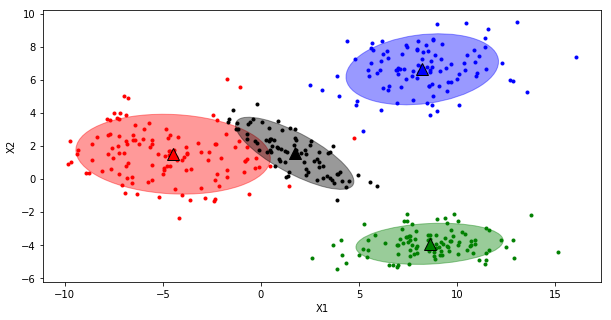

In [31]:
K = 4
D = data.shape[1]
complete_data = Data_tuple(data, K)  # Latent Variable initialized randomly        

# One hot Encoding
Z = np.zeros((complete_data.length, K))
Z[np.arange(complete_data.length), complete_data.Z] = 1
complete_data.Z = Z

em_gen = EM(K, D, complete_data)
em_gen.run_em(complete_data)

complete_data.Z = np.argmax(em_gen.p_z_given_x,axis=1)    

fig = plt.figure(figsize=(10,5))
plt.xlabel('X1')
plt.ylabel('X2')
for i in range(complete_data.length):
    plt.plot(complete_data.X[i,0], complete_data.X[i,1],clr[complete_data.Z[i]] + '.')
for k in range(K):
    plt.plot(em_gen.models[k].mean[0], em_gen.models[k].mean[1], clr[k] + '^', markersize=12,
            markeredgecolor='k')   
    ellipse = get_cov_ellipse(em_gen.models[k].covar, em_gen.models[k].mean, 1.645, clr[k])          
    ax = fig.axes[0]
    ax.add_patch(ellipse)
plt.show()

In [32]:
print("Log Likelihood: " + str(em_gen.log_likelihood(complete_data)))

Log Likelihood: -5.160688074851878
